#Movie Recommendation System
Evaluation of the performance of LighGCN model against NGCF and LightFM on the MovieLens dataset

# Environment setup

In [ ]:
# Ignore warning
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Set device to gpu if available
import torch
device = 'cpu'
if torch.cuda.is_available:
  print('All good, a Gpu is available')
  device = torch.device("cuda:0")  
else:
  print('Please set GPU via Edit -> Notebook Settings.')
  

All good, a Gpu is available


In [ ]:
!nvidia-smi

Wed Jul 20 14:16:53 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install -q torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install -q torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install -q torch-geometric

In [ ]:
# import required modules
import random
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
from torch import nn, optim, Tensor

from torch_sparse import SparseTensor, matmul

import torch.nn.functional as F

from torch_geometric.utils import structured_negative_sampling
from torch_geometric.data import download_url, extract_zip
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.typing import Adj

# Reproducibility
When **developing and debugging** Neural Networks is desirable to have a deterministic behaviour. For this reason, we are going to disable all the sources of randomness. Please note that completely reproducible results are not guaranteed across PyTorch releases, individual commits or different platforms. You can find more detailed information at this [page](https://pytorch.org/docs/stable/notes/randomness.html).
Please note that the flag `cudnn.benchmark = False` disable the auto-tuner that selects the optimal set of algorithms for your hardware and usually leads to slower runtime. 

In [ ]:
def fix_random(seed: int) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True        

In [ ]:
fix_random(42)

# Loading the Dataset

In [ ]:
base_url = 'https://files.grouplens.org/datasets/movielens/'

##Dataset ml-100k

This dataset `ml-100k.zip` consists of `100000` ratings (1-5) from `943` users on `1682` movies. Each user has rated at least 20 movies. 

In [ ]:
url = base_url + 'ml-100k.zip'
extract_zip(download_url(url, '.'), '.')

Extracting ./ml-100k.zip


In [ ]:
columns_name=['user_id','item_id','rating','timestamp']
df = pd.read_csv("./ml-100k/u.data",sep="\t",names=columns_name)
df = df[df['rating']>=3]
df

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
5,298,474,4,884182806
7,253,465,5,891628467
8,305,451,3,886324817
...,...,...,...,...
99992,721,262,3,877137285
99994,378,78,3,880056976
99995,880,476,3,880175444
99996,716,204,5,879795543


In [ ]:
print("Rating Distribution")
df.groupby(['rating'])['rating'].count()

Rating Distribution


rating
3    27145
4    34174
5    21201
Name: rating, dtype: int64

In [ ]:
# Perform a 80/20 train-test split on the interactions in the dataset
train, test = train_test_split(df.values, test_size=0.2)
train_df = pd.DataFrame(train, columns=df.columns)
test_df = pd.DataFrame(test, columns=df.columns)
val, test = train_test_split(test_df.values, test_size=0.5)
val_df = pd.DataFrame(val, columns=test_df.columns)
test_df = pd.DataFrame(test, columns=test_df.columns)

print("Train Size:\t", len(train_df))
print("Val Size:\t", len(val_df))
print("Test Size:\t", len(test_df))

Train Size:	 66016
Val Size:	 8252
Test Size:	 8252


Since we performed the train/test randomly on the interactions, not all users and items may be present in the training set. We will relabel all of users and items to ensure the highest label is the number of users and items, respectively.

In [ ]:
from sklearn import preprocessing as pp
le_user = pp.LabelEncoder()
le_item = pp.LabelEncoder()

In [ ]:
train_df['user_id_idx'] = le_user.fit_transform(train_df['user_id'].values)
train_df['item_id_idx'] = le_item.fit_transform(train_df['item_id'].values)

train_user_ids = train_df['user_id'].unique()
train_item_ids = train_df['item_id'].unique()

In [ ]:
n_users = len(train_user_ids)
n_items = len(train_item_ids)
print("Number of Unique Users : ", n_users)
print("Number of unique Items : ", n_items)

Number of Unique Users :  943
Number of unique Items :  1547


In [ ]:
# Consider only users and items seen during training to evaluate on val and tests sets
val_df = val_df[
    (val_df['user_id'].isin(train_user_ids)) & (val_df['item_id'].isin(train_item_ids))
]
test_df = test_df[
    (test_df['user_id'].isin(train_user_ids)) & (test_df['item_id'].isin(train_item_ids))
]
print(len(test_df))

8243


In [ ]:
val_df['user_id_idx'] = le_user.transform(val_df['user_id'].values)
val_df['item_id_idx'] = le_item.transform(val_df['item_id'].values)

In [ ]:
test_df['user_id_idx'] = le_user.transform(test_df['user_id'].values)
test_df['item_id_idx'] = le_item.transform(test_df['item_id'].values)

In [ ]:
# TRAIN
users_train = torch.LongTensor(train_df.user_id_idx)
items_train = torch.LongTensor(train_df.item_id_idx)

train_edge_index = torch.stack((users_train,items_train))
train_sparse_edge_index = SparseTensor(row=train_edge_index[0], col=train_edge_index[1], sparse_sizes=(n_users + n_items, n_users + n_items))

# VAL
users_val = torch.LongTensor(val_df.user_id_idx)
items_val = torch.LongTensor(val_df.item_id_idx)

val_edge_index = torch.stack((users_val,items_val))
val_sparse_edge_index = SparseTensor(row=val_edge_index[0], col=val_edge_index[1], sparse_sizes=(n_users + n_items, n_users + n_items))

# TEST
users_test = torch.LongTensor(test_df.user_id_idx)
items_test = torch.LongTensor(test_df.item_id_idx)

test_edge_index = torch.stack((users_test,items_test))
test_sparse_edge_index = SparseTensor(row=test_edge_index[0], col=test_edge_index[1], sparse_sizes=(n_users + n_items, n_users + n_items))

##Dataset ml-1m

This dataset `ml-1m.zip` consists of `1M` ratings (1-5) from `6039` users on `3596` movies. Each user has rated at least 20 movies. 

In [ ]:
url = base_url + 'ml-1m.zip'
extract_zip(download_url(url, '.'), '.')

user_path = './ml-1m/users.dat'
movie_path = './ml-1m/movies.dat'
rating_path = './ml-1m/ratings.dat'

Using existing file ml-1m.zip
Extracting ./ml-1m.zip


In [ ]:
def load_node_csv(path, sep, col_names, id):
    df = pd.read_csv(path, delimiter=sep, names=col_names, encoding='latin-1')
    mapping = {index: i for i, index in enumerate(df[id].unique())}
    return df, mapping

In [ ]:
user_df, user_mapping = load_node_csv(user_path, '::', ["UserID","Gender","Age","Occupation","Zip-code"], "UserID")
user_df

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455
...,...,...,...,...,...
6035,6036,F,25,15,32603
6036,6037,F,45,1,76006
6037,6038,F,56,1,14706
6038,6039,F,45,0,01060


In [ ]:
movie_df, movie_mapping = load_node_csv(movie_path, '::',  ["MovieID", "Title", "Genres"], "MovieID")
movie_df

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


In [ ]:
columns_name = ["user_id", "item_id", "rating", "timestamp"]
df = pd.read_csv(rating_path, delimiter="::", names=columns_name)
df = df[df['rating'] >= 4]
df

,user_id,item_id,rating,timestamp
0,1,1193,5,978300760
3,1,3408,4,978300275
4,1,2355,5,978824291
6,1,1287,5,978302039
7,1,2804,5,978300719
...,...,...,...,...
1000202,6040,1089,4,956704996
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


In [ ]:
print("Rating Distribution")
df.groupby(['rating'])['rating'].count()

Rating Distribution


rating
4    348971
5    226310
Name: rating, dtype: int64

In [ ]:
# Perform a 80/20 train-test split on the interactions in the dataset
train, test = train_test_split(df.values, test_size=0.2)
train_df = pd.DataFrame(train, columns=df.columns)
test_df = pd.DataFrame(test, columns=df.columns)
val, test = train_test_split(test_df.values, test_size=0.5)
val_df = pd.DataFrame(val, columns=test_df.columns)
test_df = pd.DataFrame(test, columns=test_df.columns)

print("Train Size:\t", len(train_df))
print("Val Size:\t", len(val_df))
print("Test Size:\t", len(test_df))

Train Size:	 460224
Val Size:	 57528
Test Size:	 57529


Since we performed the train/test randomly on the interactions, not all users and items may be present in the training set. We will relabel all of users and items to ensure the highest label is the number of users and items, respectively.

In [ ]:
from sklearn import preprocessing as pp
le_user = pp.LabelEncoder()
le_item = pp.LabelEncoder()

In [ ]:
train_df['user_id_idx'] = le_user.fit_transform(train_df['user_id'].values)
train_df['item_id_idx'] = le_item.fit_transform(train_df['item_id'].values)

train_user_ids = train_df['user_id'].unique()
train_item_ids = train_df['item_id'].unique()

In [ ]:
n_users = len(train_user_ids)
n_items = len(train_item_ids)
print("Number of Unique Users : ", n_users)
print("Number of unique Items : ", n_items)

Number of Unique Users :  6038
Number of unique Items :  3497


In [ ]:
# Consider only users and items seen during training to evaluate on val and tests sets
val_df = val_df[
    (val_df['user_id'].isin(train_user_ids)) & (val_df['item_id'].isin(train_item_ids))
]
test_df = test_df[
    (test_df['user_id'].isin(train_user_ids)) & (test_df['item_id'].isin(train_item_ids))
]
print(len(test_df))

57507


In [ ]:
val_df['user_id_idx'] = le_user.transform(val_df['user_id'].values)
val_df['item_id_idx'] = le_item.transform(val_df['item_id'].values)

In [ ]:
test_df['user_id_idx'] = le_user.transform(test_df['user_id'].values)
test_df['item_id_idx'] = le_item.transform(test_df['item_id'].values)

In [ ]:
# TRAIN
users_train = torch.LongTensor(train_df.user_id_idx)
items_train = torch.LongTensor(train_df.item_id_idx)

train_edge_index = torch.stack((users_train,items_train))
train_sparse_edge_index = SparseTensor(row=train_edge_index[0], col=train_edge_index[1], sparse_sizes=(n_users + n_items, n_users + n_items))

# VAL
users_val = torch.LongTensor(val_df.user_id_idx)
items_val = torch.LongTensor(val_df.item_id_idx)

val_edge_index = torch.stack((users_val,items_val))
val_sparse_edge_index = SparseTensor(row=val_edge_index[0], col=val_edge_index[1], sparse_sizes=(n_users + n_items, n_users + n_items))

# TEST
users_test = torch.LongTensor(test_df.user_id_idx)
items_test = torch.LongTensor(test_df.item_id_idx)

test_edge_index = torch.stack((users_test,items_test))
test_sparse_edge_index = SparseTensor(row=test_edge_index[0], col=test_edge_index[1], sparse_sizes=(n_users + n_items, n_users + n_items))

# Implementing LightGCN

## Light Graph Convolution
Between each layer, LightGCN uses the following propagation rule for user and item embeddings.

\begin{equation}
e_u^{(k+1)} = \sum_{i \in N_u} \frac{1}{\sqrt{|N_u|}\sqrt{|N_i|}} e_i^{(k)} \quad e_i^{(k+1)} = \sum_{u \in N_i} \frac{1}{\sqrt{|N_i|}\sqrt{|N_u|}} e_u^{(k)}
\end{equation}

$N_u$: the set of all neighbors of user $u$ (items liked by $u$)

$N_i$: the set of all neighbors of item $i$ (users who liked $i$)

$e_u^{(k)}$ : k-th layer user embedding

$e_i^{(k)}$ : k-th layer item embedding



## Layer Combination and Model Prediction
The only trainable parameters of LightGCN are the 0-th layer embeddings $e_u^{(0)}$ and $e_i^{(0)}$ for each user and item. We combine the embeddings obtained at each layer of propagation to form the final embeddings for all user and item, $e_u$ and $e_i$ via the follwing equation.


\begin{equation}
e_u = \sum_{k = 0}^K \alpha_k e_u^{(k)} \quad e_i = \sum_{k = 0}^K \alpha_k e_i^{(k)}
\end{equation}

$\alpha_k$ : hyperparameter which weights the contribution of the k-th layer embedding to the final embedding (usually set to $\frac{1}{K}$ which translates to the mean)

The model prediction is obtained by taking the inner product of the final user and item embeddings.

\begin{equation}
\hat{y}_{ui} = e_u^Te_i
\end{equation}



In [ ]:
from torch_geometric.nn import LGConv
from torch.nn import Sequential, Linear, Dropout, Embedding
class LGCN(torch.nn.Module):
    def __init__(self, num_users, num_items, hid_dim, n_layers, p_drop, skip_conn=False, post_proc_MLP=False):
        super(LGCN, self).__init__()

        if n_layers < 1:
            raise AssertionError('Number or convolution layers must be at least 1')

        self.num_users, self.num_items = num_users, num_items
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.skip_conn = skip_conn
        self.p_drop = p_drop
        self.post_proc_MLP = post_proc_MLP

        self.embedding = nn.Embedding(self.num_users + self.num_items, self.hid_dim)
        nn.init.normal_(self.embedding.weight, std=0.1) # Authors of LightGCN report higher results with normal initialization

        self.convs = nn.ModuleList(LGConv() for _ in range(self.n_layers))

        if post_proc_MLP:
            self.post_MLP = Sequential(
                Linear(hid_dim, hid_dim), Dropout(self.p_drop),
                Linear(hid_dim, hid_dim)
            )

    def reset_parameters(self):
        self.embedding = nn.Embedding(self.num_users + self.num_items, self.hid_dim)
        nn.init.normal_(self.embedding.weight, std=0.1)
        for conv in self.convs:
            conv.reset_parameters()
        if self.post_proc_MLP:
            self.post_MLP.reset_parameters()
        
    def forward(self, edge_index):
        emb_0 = self.embedding.weight
        embs = [emb_0]

        edge_index = torch.vstack((
            edge_index[0],
            edge_index[1] + n_users #add n_users since each node must have a unique id
        ))

        x = emb_0
        x_prev = None
        for conv in self.convs:
            x = conv(x, edge_index)

            if self.skip_conn and x_prev is not None:
                x = x + x_prev
            
            x = F.dropout(x, p=self.p_drop, training=self.training)
            x = F.relu(x)
            x_prev = x
            embs.append(x)

        out = torch.mean(torch.stack(embs, dim=0), dim=0)

        if self.post_proc_MLP:
            out = self.post_MLP(out)

        # out = torch.sigmoid(out)
    
        users_emb_0, items_emb_0 = torch.split(emb_0, (self.num_users, self.num_items))
        users_emb_k, items_emb_k = torch.split(out,   (self.num_users, self.num_items))
        # returns e_u^K, e_u^0, e_i^K, e_i^0
        return users_emb_k, users_emb_0, items_emb_k, items_emb_0

# Implementing NGCF

NGCF is an older architecture than LightGCN that originated by researchers who applied [Graph Convolutional Networks (GCNs)]() to recommender systems. LightGCN functions the same as NGCF, but removes the learnable linear layers, non-linear activation, and dropout.

One layer of NGCF updates user and item embeddings as follows:

$$e_{u}^{(k+1)} = \sigma\left(W_1 e_u^{(k)} + \sum\limits_{i \in N_u} \frac{1}{\sqrt{|N_u|}\sqrt{|N_i|}}(W_1e^{(k)}_i + W_2(e^{(k)}_i \odot e^{(k)}_u))\right)$$

$$e_{i}^{(k+1)} = \sigma\left(W_1 e_i^{(k)} + \sum\limits_{u \in N_i} \frac{1}{\sqrt{|N_i|}\sqrt{|N_u|}}(W_1e^{(k)}_u + W_2(e^{(k)}_u \odot e^{(k)}_i))\right)$$

Typically, NGCF is implemented with dropout before the activation and with an activation function $\sigma$ of LeakyReLU.

In [ ]:
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import degree
class NGCFConv(MessagePassing):
    def __init__(self, hid_dim, bias=True, **kwargs):  
        super(NGCFConv, self).__init__(aggr='add', **kwargs)

        self.W1 = nn.Linear(hid_dim, hid_dim, bias=bias)
        self.W2 = nn.Linear(hid_dim, hid_dim, bias=bias)

        self.reset_parameters()


    def reset_parameters(self):
        nn.init.xavier_uniform_(self.W1.weight)
        nn.init.xavier_uniform_(self.W2.weight)


    def forward(self, x, edge_index):
        from_, to_ = edge_index
        deg = degree(to_, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[from_] * deg_inv_sqrt[to_]

        # Message propagation
        out = self.W1(x) + self.propagate(edge_index, x=(x, x), norm=norm)
        return out


    def message(self, x_j, x_i, norm):
        return norm.view(-1, 1) * (self.W1(x_j) + self.W2(x_j * x_i))

In [ ]:
from torch.nn import Sequential, Linear, Dropout, Embedding
class NGCF(torch.nn.Module):
    def __init__(self, num_users, num_items, hid_dim, n_layers, p_drop, skip_conn=False, post_proc_MLP=False):
        super(NGCF, self).__init__()

        if n_layers < 1:
            raise AssertionError('Number or convolution layers must be at least 1')

        self.num_users, self.num_items = num_users, num_items
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.skip_conn = skip_conn
        self.p_drop = p_drop
        self.post_proc_MLP = post_proc_MLP

        self.embedding = nn.Embedding(self.num_users + self.num_items, self.hid_dim)
        nn.init.xavier_uniform_(self.embedding.weight)

        self.convs = nn.ModuleList(NGCFConv(hid_dim) for _ in range(self.n_layers))

        if post_proc_MLP:
            self.post_MLP = Sequential(
                Linear(hid_dim*(self.n_layers+1), hid_dim), Dropout(self.p_drop),
                Linear(hid_dim, hid_dim)
            )

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        if self.post_proc_MLP:
            self.post_MLP.reset_parameters()
        
    def forward(self, edge_index):
        emb_0 = self.embedding.weight
        embs = [emb_0]

        edge_index = torch.vstack((
            edge_index[0],
            edge_index[1] + n_users #add n_users since each node must have a unique id
        ))

        x = emb_0
        x_prev = None
        for conv in self.convs:
            x = conv(x, edge_index)

            if self.skip_conn and x_prev is not None:
                x = x + x_prev
            
            x = F.dropout(x, p=self.p_drop, training=self.training)
            x = F.leaky_relu(x)

            x_prev = x
            embs.append(x)

        out = torch.cat(embs, dim=-1)

        if self.post_proc_MLP:
            out = self.post_MLP(out)
    
        users_emb_0, items_emb_0 = torch.split(emb_0, (self.num_users, self.num_items))
        users_emb_k, items_emb_k = torch.split(out,   (self.num_users, self.num_items))
        # returns e_u^K, e_u^0, e_i^K, e_i^0
        return users_emb_k, users_emb_0, items_emb_k, items_emb_0

# BPR Loss Function



We utilize a Bayesian Personalized Ranking (BPR) loss, a pairwise objective which encourages the predictions of positive samples to be higher than negative samples for each user.

\begin{equation}
L_{BPR} = -\sum_{u = 1}^M \sum_{i \in N_u} \sum_{j \notin N_u} \ln{\sigma(\hat{y}_{ui} - \hat{y}_{uj})} + \lambda ||E^{(0)}||^2 
\end{equation}

$\hat{y}_{ui}$: predicted score of a positive sample

$\hat{y}_{uj}$: predicted score of a negative sample

$\lambda$: hyperparameter which controls the L2 regularization strength

In [ ]:
import math
def bpr_loss_fn(users_emb_final, users_emb_0, pos_items_emb_final, pos_items_emb_0, neg_items_emb_final, neg_items_emb_0):
    DECAY = 1e-4

    # compute loss from initial embeddings, used for regulization
    reg_loss = (1/2) * (
        users_emb_0.norm(2).pow(2) +
        pos_items_emb_0.norm(2).pow(2) +
        neg_items_emb_0.norm(2).pow(2)
    ) / float(len(users_emb_0))

    # compute BPR loss from user, positive item, and negative item embeddings
    pos_scores = torch.mul(users_emb_final, pos_items_emb_final).sum(dim=1) # predicted scores of positive samples
    neg_scores = torch.mul(users_emb_final, neg_items_emb_final).sum(dim=1) # predicted scores of negative samples

    bpr_loss = -torch.sum(torch.log(F.sigmoid(pos_scores - neg_scores)) + DECAY * reg_loss)
    #bpr_loss = F.softplus(neg_scores - pos_scores).mean() + DECAY * reg_loss
    return bpr_loss

# Evaluation Metrics

We evalaluate our model using the following metrics

\begin{equation}
\text{Recall} = \frac{TP}{TP + FP}
\end{equation}

\begin{equation}
\text{Precision} = \frac{TP}{TP + FN}
\end{equation}

**Dicounted Cumulative Gain (DCG)** at rank position p is defined as:

\begin{equation}
\text{DCG}_\text{p} = \sum_{i = 1}^p \frac{2^{rel_i} - 1}{\log_2{(i + 1)}}
\end{equation}

p: a particular rank position

$rel_i \in \{0, 1\}$ : graded relevance of the result at position $i$

**Idealised Dicounted Cumulative Gain (IDCG)**, namely the maximum possible DCG, at rank position $p$ is defined as:

\begin{equation}
\text{IDCG}_\text{p} = \sum_{i = 1}^{|REL_p|} \frac{2^{rel_i} - 1}{\log_2{(i + 1)}}
\end{equation}

$|REL_p|$ : list of items ordered by their relevance up to position p

**Normalized Dicounted Cumulative Gain (NDCG)** at rank position $p$ is defined as:

\begin{equation}
\text{nDCG}_\text{p} = \frac{\text{DCG}_p}{\text{IDCG}_p}
\end{equation}

Specifically, we use the metrics recall@K, precision@K, and NDCG@K. @K indicates that these metrics are computed on the top K recommendations.

In [ ]:
# computes recall@K and precision@K
def RecallPrecision_ATk(groundTruth, r, k):
    num_correct_pred = torch.sum(r, dim=-1) # number of correctly predicted items per user
    user_num_liked = torch.Tensor([len(groundTruth[i]) for i in range(len(groundTruth))]) # number of items liked by each user in the test set
    recall = torch.mean(num_correct_pred / user_num_liked)
    precision = torch.mean(num_correct_pred) / k
    return recall.item(), precision.item()

In [ ]:
# computes NDCG@K
def NDCGatK_r(groundTruth, r, k):
    """Computes Normalized Discounted Cumulative Gain (NDCG) @ k

    Args:
        groundTruth (list): list of lists containing highly rated items of each user
        r (list): list of lists indicating whether each top k item recommended to each user
            is a top k ground truth item or not
        k (int): determines the top k items to compute ndcg on

    Returns:
        float: ndcg @ k
    """
    assert len(r) == len(groundTruth)

    test_matrix = torch.zeros((len(r), k))

    for i, items in enumerate(groundTruth):
        length = min(len(items), k)
        test_matrix[i, :length] = 1
    max_r = test_matrix
    idcg = torch.sum(max_r * 1. / torch.log2(torch.arange(2, k + 2)), axis=1)
    dcg = r * (1. / torch.log2(torch.arange(2, k + 2)))
    dcg = torch.sum(dcg, axis=1)
    idcg[idcg == 0.] = 1.
    ndcg = dcg / idcg
    ndcg[torch.isnan(ndcg)] = 0.
    return torch.mean(ndcg).item()

In [ ]:
# computes AUC ROC
def auc_score(user_embedding, item_embedding, users, pos_items, neg_items):
    # get ratings between every user and item 
    ratings = torch.matmul(user_embedding, item_embedding.T)
    # calculate ratio of positive items having higher rating than negative items
    ratio = [ratings[users[i], pos_items[i]] > ratings[users[i], neg_items[i]] for i in range(users.shape[-1])]

    auc = sum(ratio)/len(ratio)
    return auc

In [ ]:
# Generates dictionary of positive items for each user
def get_user_positive_items(edge_index):
    df = pd.DataFrame(edge_index.cpu().numpy().T, columns=["user_id_idx", "item_id_idx"]).astype("long")
    user_pos_items_df = df.groupby('user_id_idx')['item_id_idx'].apply(list).reset_index()
    return user_pos_items_df.set_index('user_id_idx')['item_id_idx'].T.to_dict()

In [ ]:
# Computes the evaluation metrics: recall, precision, and ndcg @ K
def get_metrics(user_embedding, item_embedding, edge_index, exclude_edge_indices, k):
    # get ratings between every user and item 
    rating = torch.matmul(user_embedding, item_embedding.T)

    for exclude_edge_index in exclude_edge_indices:
        indices = exclude_edge_index
        values = torch.ones(train_edge_index.size(1), dtype=torch.float64).to(indices.device)
        interactions = torch.sparse.FloatTensor(indices, values, (n_users, n_items)).to_dense()
        
        # mask out training user-item interactions from metric computation
        rating = torch.mul(rating, (1 - interactions))

    # get the top k recommended items for each user
    _, top_K_items = torch.topk(rating, k)

    # get all unique users in evaluated split
    users = edge_index[0].unique()

    test_user_pos_items = get_user_positive_items(edge_index)

    # convert test user pos items dictionary into a list
    test_user_pos_items_list = [test_user_pos_items[user.item()] for user in users]

    # determine the correctness of topk predictions
    r = []
    for user in users:
        ground_truth_items = test_user_pos_items[user.item()]
        label = list(
            # apply to each top k item the function: 1 if it is a ground truth item else 0
            map(lambda x: x in ground_truth_items, top_K_items[user])
        )
        r.append(label)
    r = torch.Tensor(np.array(r).astype('float'))

    recall, precision = RecallPrecision_ATk(test_user_pos_items_list, r, K)
    ndcg = NDCGatK_r(test_user_pos_items_list, r, k)

    return recall, precision, ndcg

In [ ]:
# wrapper function to evaluate model
@torch.no_grad()
def evaluation(model, criterion, edge_index, sparse_edge_index, exclude_edge_indices, k):
    model.eval()

    # get embeddings
    users_emb_final, users_emb_0, items_emb_final, items_emb_0 = model(sparse_edge_index)

    # calculate metrics
    recall, precision, ndcg = get_metrics(users_emb_final, items_emb_final, edge_index, exclude_edge_indices, k)

    # negative sampling
    # Here need to pass the min value for num_nodes because the library for the function `structured_negative_sampling` is an old version and doesn't support a tuple as parameter
    user_indices, pos_item_indices, neg_item_indices = structured_negative_sampling(edge_index, num_nodes=min([n_users, n_items]), contains_neg_self_loops=False)

    auc = auc_score(users_emb_final, items_emb_final, user_indices, pos_item_indices, neg_item_indices)

    users_emb_final, users_emb_0 = users_emb_final[user_indices], users_emb_0[user_indices]
    pos_items_emb_final, pos_items_emb_0 = items_emb_final[pos_item_indices], items_emb_0[pos_item_indices]
    neg_items_emb_final, neg_items_emb_0 = items_emb_final[neg_item_indices], items_emb_0[neg_item_indices]

    # calculate loss
    loss = criterion(users_emb_final, users_emb_0, pos_items_emb_final, pos_items_emb_0, neg_items_emb_final, neg_items_emb_0)
    
    return loss, recall, precision, ndcg, auc

# Train and evaluation

In [ ]:
def sample_mini_batch(batch_size, edge_index):

    def sample_neg(x):
        while True:
            neg_id = random.randint(0, n_items - 1)
            if neg_id not in x:
                return neg_id

    data = pd.DataFrame(edge_index.cpu().numpy().T, columns=["user_id_idx", "item_id_idx"]).astype("long")
    interected_items_df = data.groupby('user_id_idx')['item_id_idx'].apply(list).reset_index()
    indices = [x for x in range(n_users)]

    if n_users < batch_size:
        users = [random.choice(indices) for _ in range(batch_size)]
    else:
        users = random.sample(indices, batch_size)
    users.sort()
    users_df = pd.DataFrame(users,columns = ['users'])

    interected_items_df = pd.merge(interected_items_df, users_df, how = 'right', left_on = 'user_id_idx', right_on = 'users')
    pos_items = interected_items_df['item_id_idx'].apply(lambda x : random.choice(x)).values
    neg_items = interected_items_df['item_id_idx'].apply(lambda x: sample_neg(x)).values

    return (
        torch.LongTensor(list(users)).to(device), 
        torch.LongTensor(list(pos_items)).to(device),
        torch.LongTensor(list(neg_items)).to(device)
    )

sample_mini_batch(1024, train_edge_index)

(tensor([   3,    4,   13,  ..., 6028, 6033, 6037], device='cuda:0'),
 tensor([2342,  917, 1095,  ..., 1044,  925, 2791], device='cuda:0'),
 tensor([2478,  628, 2781,  ..., 1174,   70, 2057], device='cuda:0'))

##LGCN

In [ ]:
BATCH_SIZE = 1024*10
EPOCHS = 50

LR = 5e-3
WD = 1e-5
EVAL_STEPS = 5
LR_DECAY_STEPS = 10
K = 20

train_edge_index = train_edge_index.to(device)

val_edge_index = val_edge_index.to(device)

test_edge_index = test_edge_index.to(device)

best_test_precision = 0
best_model_history = None
best_model_weight = None

from sklearn.model_selection import ParameterGrid
configs = {
    'HIDDEN_DIM' : [64],
    'DROPOUT' : [0.1],
    'N_LAYERS' : [2],
    'SKIP_CONN' : [False],
    'POST_PROC_MLP' : [False]
}
param_grid = ParameterGrid(configs)
print(f'Number of combinations: {len(param_grid)}')
print('------------------')
for dict_ in param_grid:
    print(f'Trying configuration {dict_}')

    #MODEL
    model = LGCN(n_users, n_items, dict_['HIDDEN_DIM'], dict_['N_LAYERS'], dict_['DROPOUT'], skip_conn=dict_['SKIP_CONN'], post_proc_MLP=dict_['POST_PROC_MLP']).to(device)

    criterion = bpr_loss_fn

    optimizer = torch.optim.Adam(model.parameters(), lr=LR)

    #TRAIN & EVALUATE
    history = {}
    history['loss'] = []; history['val_loss'] = []; history['test_loss'] = []
    history[f'val_recall@{K}'] = []; history[f'test_recall@{K}'] = []
    history[f'val_precision@{K}'] = []; history[f'test_precision@{K}'] = []
    history[f'val_nDCG@{K}'] = []; history[f'test_nDCG@{K}'] = []
    history[f'val_auc'] = []; history[f'test_auc'] = []
    
    n_batch = train_edge_index.size(1)//BATCH_SIZE

    pbar = tqdm(range(EPOCHS))
    for epoch in pbar:

        model.train()
        losses = []
        for _ in range(n_batch):
            optimizer.zero_grad()

            # batching
            user_indices, pos_item_indices, neg_item_indices = sample_mini_batch(BATCH_SIZE, train_edge_index)

            # forward propagation
            users_emb_final, users_emb_0, items_emb_final, items_emb_0 = model(train_edge_index)

            # select batch samples 
            users_emb_final, users_emb_0 = users_emb_final[user_indices], users_emb_0[user_indices]
            pos_items_emb_final, pos_items_emb_0 = items_emb_final[pos_item_indices], items_emb_0[pos_item_indices]
            neg_items_emb_final, neg_items_emb_0 = items_emb_final[neg_item_indices], items_emb_0[neg_item_indices]

            # loss computation
            loss = criterion(users_emb_final, users_emb_0, pos_items_emb_final, pos_items_emb_0, neg_items_emb_final, neg_items_emb_0)
            loss.backward()
            optimizer.step()

            losses.append(loss.item())
        
        history['loss'].append(np.mean(losses))

        if (epoch + 1) % EVAL_STEPS == 0 or epoch == 0:
            val_loss, val_recall, val_precision, val_nDCG, val_auc = evaluation(model, criterion, val_edge_index, train_edge_index, [train_edge_index], K)
            history['val_loss'].append(val_loss.item())
            history[f'val_recall@{K}'].append(val_recall)
            history[f'val_precision@{K}'].append(val_precision)
            history[f'val_nDCG@{K}'].append(val_nDCG)
            history[f'val_auc'].append(val_auc)

            test_loss, test_recall, test_precision, test_nDCG, test_auc = evaluation(model, criterion, test_edge_index, train_edge_index, [train_edge_index], K)
            history['test_loss'].append(test_loss.item())
            history[f'test_recall@{K}'].append(test_recall)
            history[f'test_precision@{K}'].append(test_precision)
            history[f'test_nDCG@{K}'].append(test_nDCG)
            history[f'test_auc'].append(test_auc)

        description = f"Epoch {(epoch + 1):02d} - loss: {loss:.4f} - val_nDCG@{K}: {val_nDCG:.4f} - val_recall@{K}: {val_recall:.4f} - val_precision@{K}: {val_precision:.4f} - val_auc: {val_auc:.4f} - test_nDCG@{K}: {test_nDCG:.4f} - test_recall@{K}: {test_recall:.4f} - test_precision@{K}: {test_precision:.4f} - test_auc: {test_auc:.4f}\t"
        pbar.set_description(description, refresh=True)

    print('------------------')
    
    if max(history[f'test_precision@{K}']) > best_test_precision:
        best_parameters = dict_
        best_model_history = history
        best_model_weights = model.state_dict()
        best_test_precision = max(history[f'test_precision@{K}'])
    
    del model
    torch.cuda.empty_cache()

Number of combinations: 1
------------------
Trying configuration {'DROPOUT': 0.1, 'HIDDEN_DIM': 64, 'N_LAYERS': 2, 'POST_PROC_MLP': False, 'SKIP_CONN': False}


Epoch 50 - loss: 557.8469 - val_nDCG@20: 0.1983 - val_recall@20: 0.2558 - val_precision@20: 0.0977 - val_auc: 0.9034 - test_nDCG@20: 0.1981 - test_recall@20: 0.2515 - test_precision@20: 0.0958 - test_auc: 0.9040	: 100%|██████████| 50/50 [18:02<00:00, 21.64s/it]

------------------


In [ ]:
print(f'Best parameters: {best_parameters}')

Best parameters: {'DROPOUT': 0.1, 'HIDDEN_DIM': 64, 'N_LAYERS': 2, 'POST_PROC_MLP': False, 'SKIP_CONN': False}


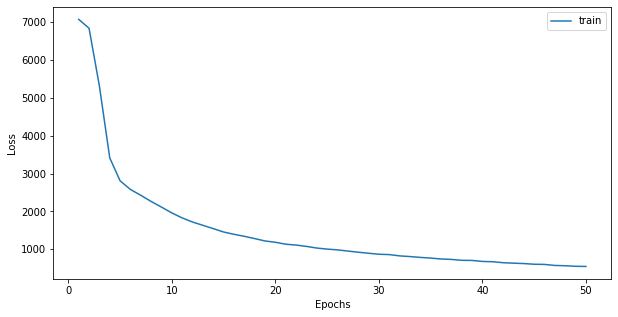

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(1, EPOCHS+1), best_model_history['loss'], label="train")
# plt.plot(np.arange(0, EPOCHS+1, EVAL_STEPS), best_model_history['val_loss'], label="validation")
# plt.plot(np.arange(0, EPOCHS+1, EVAL_STEPS), best_model_history['test_loss'], label="test")

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

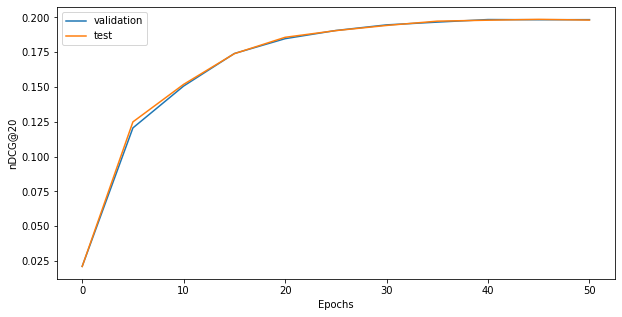

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(0, EPOCHS+1, EVAL_STEPS), best_model_history[f'val_nDCG@{K}'], label="validation")
plt.plot(np.arange(0, EPOCHS+1, EVAL_STEPS), best_model_history[f'test_nDCG@{K}'], label="test")

plt.xlabel('Epochs')
plt.ylabel(f'nDCG@{K}')
plt.legend(loc='upper left')
plt.show()

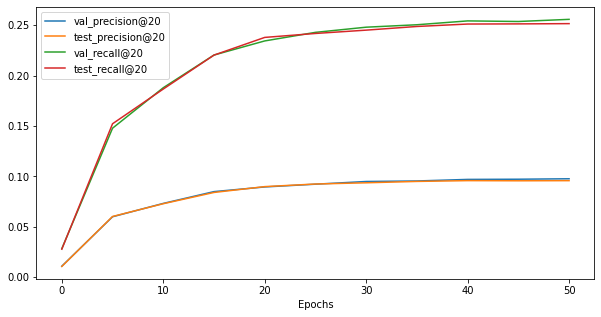

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(0, EPOCHS+1, EVAL_STEPS), best_model_history[f'val_precision@{K}'], label=f'val_precision@{K}')
plt.plot(np.arange(0, EPOCHS+1, EVAL_STEPS), best_model_history[f'test_precision@{K}'], label=f'test_precision@{K}')
plt.plot(np.arange(0, EPOCHS+1, EVAL_STEPS), best_model_history[f'val_recall@{K}'], label=f'val_recall@{K}')
plt.plot(np.arange(0, EPOCHS+1, EVAL_STEPS), best_model_history[f'test_recall@{K}'], label=f'test_recall@{K}')

plt.xlabel('Epochs')
plt.legend(loc='upper left')
plt.show()

##NGCF

In [ ]:
BATCH_SIZE = 1024*10
EPOCHS = 50

LR = 5e-3
WD = 1e-5
EVAL_STEPS = 5
LR_DECAY_STEPS = 10
K = 20

train_edge_index = train_edge_index.to(device)

val_edge_index = val_edge_index.to(device)

test_edge_index = test_edge_index.to(device)

best_test_precision = 0
best_model_history = None
best_model_weight = None

from sklearn.model_selection import ParameterGrid
configs = {
    'HIDDEN_DIM' : [64],
    'DROPOUT' : [0.1],
    'N_LAYERS' : [2],
    'SKIP_CONN' : [False],
    'POST_PROC_MLP' : [False]
}
param_grid = ParameterGrid(configs)
print(f'Number of combinations: {len(param_grid)}')
print('------------------')
for dict_ in param_grid:
    print(f'Trying configuration {dict_}')

    #MODEL
    model = NGCF(n_users, n_items, dict_['HIDDEN_DIM'], dict_['N_LAYERS'], dict_['DROPOUT'], skip_conn=dict_['SKIP_CONN'], post_proc_MLP=dict_['POST_PROC_MLP']).to(device)

    criterion = bpr_loss_fn

    optimizer = torch.optim.Adam(model.parameters(), lr=LR)

    #TRAIN & EVALUATE
    history = {}
    history['loss'] = []; history['val_loss'] = []; history['test_loss'] = []
    history[f'val_recall@{K}'] = []; history[f'test_recall@{K}'] = []
    history[f'val_precision@{K}'] = []; history[f'test_precision@{K}'] = []
    history[f'val_nDCG@{K}'] = []; history[f'test_nDCG@{K}'] = []
    history[f'val_auc'] = []; history[f'test_auc'] = []
    
    n_batch = train_edge_index.size(1)//BATCH_SIZE

    pbar = tqdm(range(EPOCHS))
    for epoch in pbar:

        model.train()
        losses = []
        for _ in range(n_batch):
            optimizer.zero_grad()

            # batching
            user_indices, pos_item_indices, neg_item_indices = sample_mini_batch(BATCH_SIZE, train_edge_index)

            # forward propagation
            users_emb_final, users_emb_0, items_emb_final, items_emb_0 = model(train_edge_index)

            # select batch samples 
            users_emb_final, users_emb_0 = users_emb_final[user_indices], users_emb_0[user_indices]
            pos_items_emb_final, pos_items_emb_0 = items_emb_final[pos_item_indices], items_emb_0[pos_item_indices]
            neg_items_emb_final, neg_items_emb_0 = items_emb_final[neg_item_indices], items_emb_0[neg_item_indices]

            # loss computation
            loss = criterion(users_emb_final, users_emb_0, pos_items_emb_final, pos_items_emb_0, neg_items_emb_final, neg_items_emb_0)
            loss.backward()
            optimizer.step()

            losses.append(loss.item())
        
        history['loss'].append(np.mean(losses))

        if (epoch + 1) % EVAL_STEPS == 0 or epoch == 0:
            val_loss, val_recall, val_precision, val_nDCG, val_auc = evaluation(model, criterion, val_edge_index, train_edge_index, [train_edge_index], K)
            history['val_loss'].append(val_loss.item())
            history[f'val_recall@{K}'].append(val_recall)
            history[f'val_precision@{K}'].append(val_precision)
            history[f'val_nDCG@{K}'].append(val_nDCG)
            history[f'val_auc'].append(val_auc)

            test_loss, test_recall, test_precision, test_nDCG, test_auc = evaluation(model, criterion, test_edge_index, train_edge_index, [train_edge_index], K)
            history['test_loss'].append(test_loss.item())
            history[f'test_recall@{K}'].append(test_recall)
            history[f'test_precision@{K}'].append(test_precision)
            history[f'test_nDCG@{K}'].append(test_nDCG)
            history[f'test_auc'].append(test_auc)

        description = f"Epoch {(epoch + 1):02d} - loss: {loss:.4f} - val_nDCG@{K}: {val_nDCG:.4f} - val_recall@{K}: {val_recall:.4f} - val_precision@{K}: {val_precision:.4f} - val_auc: {val_auc:.4f} - test_nDCG@{K}: {test_nDCG:.4f} - test_recall@{K}: {test_recall:.4f} - test_precision@{K}: {test_precision:.4f} - test_auc: {test_auc:.4f}\t"
        pbar.set_description(description, refresh=True)

    print('------------------')
    
    if max(history[f'test_precision@{K}']) > best_test_precision:
        best_parameters = dict_
        best_model_history = history
        best_model_weights = model.state_dict()
        best_test_precision = max(history[f'test_precision@{K}'])
    
    del model
    torch.cuda.empty_cache()

Number of combinations: 1
------------------
Trying configuration {'DROPOUT': 0.1, 'HIDDEN_DIM': 64, 'N_LAYERS': 2, 'POST_PROC_MLP': False, 'SKIP_CONN': False}


Epoch 50 - loss: 795.5643 - val_nDCG@20: 0.1879 - val_recall@20: 0.2426 - val_precision@20: 0.0923 - val_auc: 0.8999 - test_nDCG@20: 0.1881 - test_recall@20: 0.2427 - test_precision@20: 0.0913 - test_auc: 0.8992	: 100%|██████████| 50/50 [19:15<00:00, 23.12s/it]

------------------


In [ ]:
print(f'Best parameters: {best_parameters}')

Best parameters: {'DROPOUT': 0.1, 'HIDDEN_DIM': 64, 'N_LAYERS': 2, 'POST_PROC_MLP': False, 'SKIP_CONN': False}


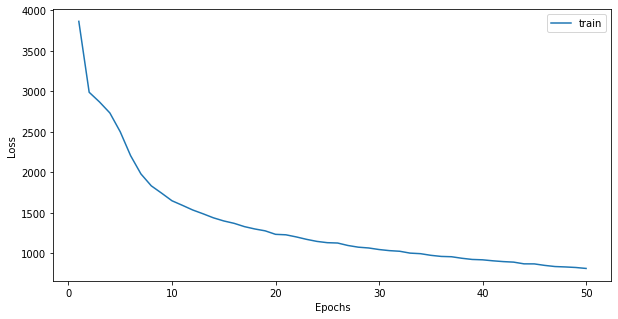

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(1, EPOCHS+1), best_model_history['loss'], label="train")
# plt.plot(np.arange(0, EPOCHS+1, EVAL_STEPS), best_model_history['val_loss'], label="validation")
# plt.plot(np.arange(0, EPOCHS+1, EVAL_STEPS), best_model_history['test_loss'], label="test")

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

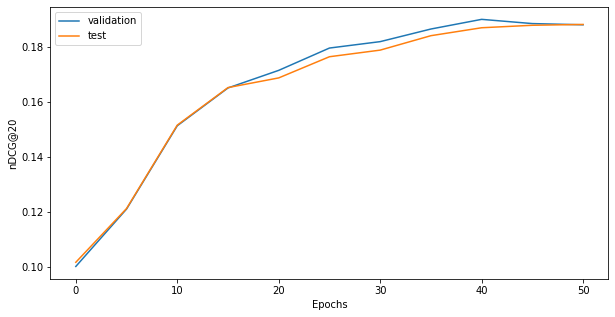

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(0, EPOCHS+1, EVAL_STEPS), best_model_history[f'val_nDCG@{K}'], label="validation")
plt.plot(np.arange(0, EPOCHS+1, EVAL_STEPS), best_model_history[f'test_nDCG@{K}'], label="test")

plt.xlabel('Epochs')
plt.ylabel(f'nDCG@{K}')
plt.legend(loc='upper left')
plt.show()

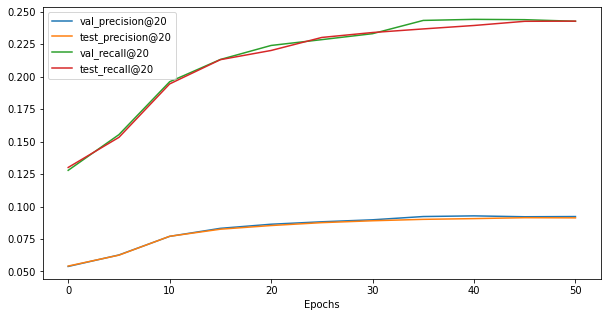

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(0, EPOCHS+1, EVAL_STEPS), best_model_history[f'val_precision@{K}'], label=f'val_precision@{K}')
plt.plot(np.arange(0, EPOCHS+1, EVAL_STEPS), best_model_history[f'test_precision@{K}'], label=f'test_precision@{K}')
plt.plot(np.arange(0, EPOCHS+1, EVAL_STEPS), best_model_history[f'val_recall@{K}'], label=f'val_recall@{K}')
plt.plot(np.arange(0, EPOCHS+1, EVAL_STEPS), best_model_history[f'test_recall@{K}'], label=f'test_recall@{K}')

plt.xlabel('Epochs')
plt.legend(loc='upper left')
plt.show()

# Evaluation of LightFM model

In [ ]:
%%capture
!pip install lightfm

In [ ]:
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm.datasets import fetch_movielens
from lightfm.evaluation import precision_at_k, recall_at_k, auc_score
from sklearn.metrics import ndcg_score

In [ ]:
from scipy.sparse import coo_matrix
# Train interactions
row = train_edge_index[0].cpu().numpy()
col = train_edge_index[1].cpu().numpy()
train_sparse_matrix = coo_matrix((np.ones(col.shape), (row, col)), shape=(n_users, n_items))
# Test interactions
row = test_edge_index[0].cpu().numpy()
col = test_edge_index[1].cpu().numpy()
test_sparse_matrix = coo_matrix((np.ones(col.shape), (row, col)), shape=(n_users, n_items))

In [ ]:
# Extract year from the title as another feature
import re
def extract_year(title):
    return re.findall(r'\(.*?\)', title)[0]
movie_df['Year'] = movie_df['Title'].apply(extract_year)
movie_df['Title'] = movie_df['Title'].str.rsplit(" ", 1).str[0]
movie_df.head()

,MovieID,Title,Genres,Year
0,1,Toy Story,Animation|Children's|Comedy,(1995)
1,2,Jumanji,Adventure|Children's|Fantasy,(1995)
2,3,Grumpier Old Men,Comedy|Romance,(1995)
3,4,Waiting to Exhale,Comedy|Drama,(1995)
4,5,Father of the Bride Part II,Comedy,(1995)


In [ ]:
# Build a mapping between features and unique values
def feature_mapping(input_df, cols):
    columns = []
    for col in cols:
        columns += [col]*len(input_df[col].unique())

    unique_feats = []
    for col in cols:
        unique_feats += list(input_df[col].unique())
    
    feats = []
    for c,f in zip(columns, unique_feats):
        feats.append(str(c) + ":" + str(f))
    return feats

# User features mapping
user_feat_cols = list(user_df.columns)[1:]
user_feature_mapping = feature_mapping(user_df, user_feat_cols)
print(user_feature_mapping[:10])
# Item features mapping
item_feat_cols = list(movie_df.columns)[1:]
item_feature_mapping = feature_mapping(movie_df, item_feat_cols)
print(item_feature_mapping[:10])

['Gender:F', 'Gender:M', 'Age:1', 'Age:56', 'Age:25', 'Age:45', 'Age:50', 'Age:35', 'Age:18', 'Occupation:10']
['Title:Toy Story', 'Title:Jumanji', 'Title:Grumpier Old Men', 'Title:Waiting to Exhale', 'Title:Father of the Bride Part II', 'Title:Heat', 'Title:Sabrina', 'Title:Tom and Huck', 'Title:Sudden Death', 'Title:GoldenEye']


In [ ]:
# Build the dataset
movielens1M = Dataset()
movielens1M.fit(
        user_df['UserID'].unique(),     # all the users
        movie_df['MovieID'].unique(),   # all the items
        user_features=user_feature_mapping,
        item_features=item_feature_mapping,
)

We need now to convert features in the following format:
```
[
(user1 ,  [feature1:value1, feature2:value2, feature3:value3, ...]),
(user2 ,  [feature1:value1, feature2:value2, feature3:value3, ...]),
(user3 ,  [feature1:value1, feature2:value2, feature3:value3, ...]),
...
]
```

to pass them to  `build_user_features`/`build_item_features` methods

In [ ]:
# Helper function that takes the user features and converts them into the proper "feature:value" format
def feature_colon_value(my_list, feature_cols):
    result = []
    ll = feature_cols
    aa = my_list
    for x,y in zip(ll,aa):
        res = str(x) + ":" + str(y)
        result.append(res)
    return result

feature_colon_value([1,1,0,'rome'], ["f1", 'f2','f3', 'loc'])

['f1:1', 'f2:1', 'f3:0', 'loc:rome']

In [ ]:
# Using the helper function to generate user features in proper format for ALL users
def feature_formatter(input_df, feature_cols):
    ad_subset = input_df[feature_cols]
    ad_list = [list(x) for x in ad_subset.values]

    feature_list = []
    for item in ad_list:
        feature_list.append(feature_colon_value(item, feature_cols))
    
    return feature_list

user_feats = feature_formatter(user_df, user_feat_cols)
print(user_feats[:5])
item_feats = feature_formatter(movie_df, item_feat_cols)
print(item_feats[:5])

[['Gender:F', 'Age:1', 'Occupation:10', 'Zip-code:48067'], ['Gender:M', 'Age:56', 'Occupation:16', 'Zip-code:70072'], ['Gender:M', 'Age:25', 'Occupation:15', 'Zip-code:55117'], ['Gender:M', 'Age:45', 'Occupation:7', 'Zip-code:02460'], ['Gender:M', 'Age:25', 'Occupation:20', 'Zip-code:55455']]
[['Title:Toy Story', "Genres:Animation|Children's|Comedy", 'Year:(1995)'], ['Title:Jumanji', "Genres:Adventure|Children's|Fantasy", 'Year:(1995)'], ['Title:Grumpier Old Men', 'Genres:Comedy|Romance', 'Year:(1995)'], ['Title:Waiting to Exhale', 'Genres:Comedy|Drama', 'Year:(1995)'], ['Title:Father of the Bride Part II', 'Genres:Comedy', 'Year:(1995)']]


In [ ]:
# Build tuple
user_tuple = list(zip(user_df['UserID'], user_feats))
print(user_tuple)
item_tuple = list(zip(movie_df['MovieID'], item_feats))
print(item_tuple)

[(1, ['Gender:F', 'Age:1', 'Occupation:10', 'Zip-code:48067']), (2, ['Gender:M', 'Age:56', 'Occupation:16', 'Zip-code:70072']), (3, ['Gender:M', 'Age:25', 'Occupation:15', 'Zip-code:55117']), (4, ['Gender:M', 'Age:45', 'Occupation:7', 'Zip-code:02460']), (5, ['Gender:M', 'Age:25', 'Occupation:20', 'Zip-code:55455']), (6, ['Gender:F', 'Age:50', 'Occupation:9', 'Zip-code:55117']), (7, ['Gender:M', 'Age:35', 'Occupation:1', 'Zip-code:06810']), (8, ['Gender:M', 'Age:25', 'Occupation:12', 'Zip-code:11413']), (9, ['Gender:M', 'Age:25', 'Occupation:17', 'Zip-code:61614']), (10, ['Gender:F', 'Age:35', 'Occupation:1', 'Zip-code:95370']), (11, ['Gender:F', 'Age:25', 'Occupation:1', 'Zip-code:04093']), (12, ['Gender:M', 'Age:25', 'Occupation:12', 'Zip-code:32793']), (13, ['Gender:M', 'Age:45', 'Occupation:1', 'Zip-code:93304']), (14, ['Gender:M', 'Age:35', 'Occupation:0', 'Zip-code:60126']), (15, ['Gender:M', 'Age:25', 'Occupation:7', 'Zip-code:22903']), (16, ['Gender:F', 'Age:35', 'Occupation:0'

In [ ]:
user_features = movielens1M.build_user_features(user_tuple, normalize=False)
print(f"User dense features:\n{user_features.todense()}")
item_features = movielens1M.build_item_features(item_tuple, normalize=False)
print(f"Item dense features:\n{item_features.todense()}")

User dense features:
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Item dense features:
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
# Instantiate and train the model
model = LightFM(
    no_components=64,
    learning_schedule='adagrad',
    loss='bpr', # in alternative `warp` loss to optimize precision
    learning_rate=LR
)
model = model.fit(
    train_sparse_matrix, #train interactions
    user_features = user_features, #user features
    item_features = item_features, #item features
    epochs=500,
    num_threads=4
)

In [ ]:
# Evaluate the model trained with features
# recall, precision and roc auc for each user (need to perform mean)
test_recall = recall_at_k(model, test_sparse_matrix, train_sparse_matrix, k=K, user_features=user_features, item_features = item_features).mean()
test_precision = precision_at_k(model, test_sparse_matrix, train_sparse_matrix, k=K, user_features=user_features, item_features = item_features).mean()
test_auc = auc_score(model, test_sparse_matrix, train_sparse_matrix, user_features=user_features, item_features = item_features).mean()
print(f'Recall@{K}:\t{test_recall:.4f}')
print(f'Precision@{K}:\t{test_precision:.4f}')
print(f'AUC score:\t{test_auc:.4f}')

Recall@20:	0.2031
Precision@20:	0.0866
AUC score:	0.9313


In [ ]:
# Instantiate and train the model
model = LightFM(
    no_components=64,
    learning_schedule='adagrad',
    loss='bpr', # in alternative `warp` loss to optimize precision
    learning_rate=LR
)
model = model.fit(
    train_sparse_matrix,
    epochs=500,
    num_threads=4
)

In [ ]:
# Evaluate the model trained without features
# recall, precision and roc auc for each user (need to perform mean)
test_recall = recall_at_k(model, test_sparse_matrix, train_sparse_matrix, k=K).mean()
test_precision = precision_at_k(model, test_sparse_matrix, train_sparse_matrix, k=K).mean()
test_auc = auc_score(model, test_sparse_matrix, train_sparse_matrix).mean()
print(f'Recall@{K}:\t{test_recall:.4f}')
print(f'Precision@{K}:\t{test_precision:.4f}')
print(f'AUC score:\t{test_auc:.4f}')

Recall@20:	0.1549
Precision@20:	0.0667
AUC score:	0.9018
